# Using Machine Leraning Services involves the following steps.

#Register the model in a Machine Learning Model Registry hosted in Azure Machine Learning Service workspace

#Register an image that pairs a model with an inference script and dependencies required to create a docker container providing the compute environment to run the pipeline.

#Monitor and collect data about model training, performance, and deployments.


# Create a deployment workspace in the Azure portal

1) Sign into the Azure portal  with your Azure subscription.
2) Select + Create a resource in the left sidebar of the Azure portal.
3) Type machine learning service in the search bar.
4) Select the Machine Learning service workspace in the search results.
5) Select the Create button to open the ML service workspace creation panel.
6) Fill in the details required using the following suggestions:
#*Workspace name - enter a workspace name such as learn-workspace.
#*Subscription - select an Azure subscription to own this resource.
#*Resource group - create a new resource group named mslearn-amls. We'll delete this resource group when we're done.
#*Location - Select a location where the workspace will be created. You will typically want to select a location near where the workspace will be used.

# Create a deployment workspace using the Azure ML SDK and Python

In [ ]:
from azureml.core import Workspace

ws = Workspace.create(
            name='learn-workspace-py',
            subscription_id='', 
            resource_group='',
            create_resource_group=False,
            location=''

print('Done')
)

As with the portal approach, it takes a few minutes to set up the workspace. After the workspace is provisioned, you can view the workspace details, such as the associated Azure Blob Storage account, Docker container registry account, and key vault through the returned ws object - try executing the get_details() function on it.

In [32]:
from azureml.core import Workspace,Experiment,Run

ws = Workspace.get(name='',
            subscription_id='', 
            resource_group='')
print(ws)

In [3]:
ws.get_details()

{'id': '/subscriptions/83b057f2-5b13-476b-97e7-8da4927e2f61/resourceGroups/entrenamiento-idata/providers/Microsoft.MachineLearningServices/workspaces/AMLSWorkspace',
 'name': 'AMLSWorkspace',
 'location': 'eastus2',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'sku': 'Basic',
 'workspaceid': '1bcb4b94-f6a6-473e-9775-05622686f66d',
 'description': '',
 'friendlyName': 'AMLSWorkspace',
 'creationTime': '2019-11-20T21:10:13.3102038+00:00',
 'containerRegistry': '/subscriptions/83b057f2-5b13-476b-97e7-8da4927e2f61/resourceGroups/entrenamiento-idata/providers/Microsoft.ContainerRegistry/registries/amlsworkspac2bc26995',
 'keyVault': '/subscriptions/83b057f2-5b13-476b-97e7-8da4927e2f61/resourcegroups/entrenamiento-idata/providers/microsoft.keyvault/vaults/amlsworkkeyvaultd573ec01',
 'applicationInsights': '/subscriptions/83b057f2-5b13-476b-97e7-8da4927e2f61/resourcegroups/entrenamiento-idata/providers/microsoft.insights/components/amlsworkinsights45dc8cb6',
 'identityPrincipalId

# Register an Azure ML model with Python

After creating a workspace using the Azure portal or Python, you can register your model in the workspace for further use. Like a container registry, the model registry is a single place to keep track of all the models in your Azure Machine Learning service, to make sure that the models are stored in a structured format.

In the training script we used to train the model, the last step is to save the model as a pickle file. It is this file you will register for deployment.

To run the code below, you need to train model and save it to a pickle file as explained in the module "Train a local model with Azure Machine Learning service".

In [18]:
from azureml.core.model import Model
# Tip: When model_path is set to a directory, you can use the child_paths parameter to include
#      only some of the files from the directory
model = Model.register(model_path = "outputs/sklearn_mnist_model.pkl",
                       model_name = "sklearn_mnist_model.pkl",
                       description = "identify numbers",
                       workspace = ws)

Registering model sklearn_mnist_model.pkl


In [20]:
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist_model.pkl	sklearn_mnist_model.pkl:1	1


# Create a scoring script

Container images allow users to deploy models reliably since the machine learning model always depends on some other dependencies such as PyTorch. Using containers to deploy machine learning models can avoid dependency issues.

A container image has the following items packaged, which you need to prepare:

#The model itself
#The inference engine, such as PyTorch
#The scoring file (score.py) or other application consuming the model
#Any dependencies needed

The first step is to create the score.py file that consumes the model, like below. You only need to define two functions: init, which loads the model and run, which does the inference:

 model scoring script used to define the call parameters needed by the REST API

In [21]:
%%writefile score.py
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import numpy
import json

def init():
    global model
    model_path = Model.get_model_path('sklearn_mnist_model.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = numpy.array(data)
        result = model.predict(data)
        # you can return any datatype if it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


The second step is to make sure the dependencies are included in the image. Azure Machine Learning does that by creating a conda dependency file:

# Create the environment YAML file

YAML: is a human-readable data-serialization language. It is commonly used for configuration files and in applications where data is being stored or transmitted.

In [22]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

print('Done')

Done


# Create a container image for a trained model

You registered the model already if you did the prior unit 'Register an Azure ML model with Python'. But just so you have the model object variable handy, register it again with the code below.

In [ ]:
# register model
#model = run.register_model(model_name='sklearn_mnist_model.pkl',
#                           model_path='outputs/sklearn_mnist_model.pkl')

#print(model.name, model.id, model.version, sep='\t')

Now you will prepare the container image. The following Python code uses the Azure ML SDK to create the image.



container image that defines the requirements of the deployment container

In [23]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="myenv.yml",
                                 tags = {'data': "MNIST", 'type': "sklearn"},
                                 description = "Image for sklearn model")

image = Image.create(name = "myimage1",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

print('Done')

Creating image
Running.....................................
Succeeded
Image creation operation finished for image myimage1:1, operation "Succeeded"
Done


After the code is executed, you can view the images in the Azure Machine Learning service portal:



# Choose where to Deploy your model


Once a model has been trained and you are ready to make it available to your applications and services, you need to deploy it. Deploying a model allows it to receive data from a client, process the data with the trained model, and return results back to the client.

The Azure Machine Learning Service provides several places you can deploy your trained model using the Azure Machine Learning SDK, including: 
Azure Container Instances (ACI), Azure Kubernetes Service (AKS), Azure Machine Learning Compute, Azure IoT Edge, Field-programmable gate array (FPGA)

# Deploy the model as a web service

Now that we have an image that contains our trained model, we can use Azure Container Instances to deploy the trained model as a web service. There are two steps involved:

1) Define the deployment configuration. The deployment configuration defines the compute to be created to serve the model to scoring applications. For example, the following code defines a container that uses 1 CPU and 1 GB of memory:

In [24]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                          memory_gb = 1, 
                                          tags = {"data": "mnist", "type": "sklearn"}, 
                                          description = 'Handwriting recognition')

print('Done')

Done


2) In a prior unit, you created an image and stored it in an object named image. To deploy the image, you can use code similar to the code below:

In [25]:
from azureml.core.webservice import Webservice

service_name = 'aci-mnist-1'

service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                            image = image,
                                            name = service_name,
                                            workspace = ws)

service.wait_for_deployment(show_output = True)

print('Done')

Running.............
Succeeded
ACI service creation operation finished, operation "Succeeded"
Done


It takes around 3 to 4 minutes for the web service to deploy. Once it's deployed, we can call it from a client application.



# Score data with the deployed model

Since the model is deployed as a web service that exposes a REST API, it can be tested with many tools. Azure Machine Learning SDK has a built-in testing tool that can work with the deployed web service, like below:

In [26]:
import os 

import gzip
import struct
import numpy as np


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

data_folder = os.path.join(os.getcwd(), 'data')

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(
    data_folder, 'test-labels.gz'), True).reshape(-1)

print('Done')

Done


Now score some data with the code below.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


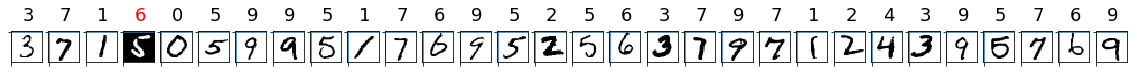

In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))
#plt.figure(figsize=(9, 3))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)

    i = i + 1

plt.show()

The key part of the code is the service.run call, which sends a JSON formatted document to the deployed web service and the result is displayed.

You can also call the model using a REST API. The code below will call the model to identify a number randomly selected from an array.

In [31]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to include the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://5b784eb3-c1cb-417a-b7dc-587f93f54780.eastus2.azurecontainer.io/score
label: 9
prediction: [9]


Cleanup
To avoid additional costs in your Azure account, delete the mslearn-amls resource group. To remove all the resources we created in this module, follow these steps.

Sign into the Azure portal .

Find the mslearn-amls resource group by selecting Resource groups in the Azure sidebar.

Select the resource group, and right-click on the row to open the context menu. You also can use the "..." button on the far-right side of the row.

Select Delete resource group.

Enter the name of the resource group, and select Delete. Azure removes all the resources for you.

# Connect to your workspace

In [ ]:
from azureml.core import Workspace, Experiment, Run

ws = Workspace.get(name='{name}',
                   subscription_id='{azure-subscription-id}',
                   resource_group='{resource-group-name}'
                  )

print('Done')